In [71]:
library(tidyverse)
library(clusterProfiler)
library(BiocParallel)
library(parallel)
library(org.Hs.eg.db)
library(AnnotationDbi)
library(stats4)
library(BiocGenerics)

# Custom package
library(rutils)

In [72]:
dirs <- rutils::get_dev_directories(dev_paths_file = "../dev_paths.txt")
unified_dsets <- c("unified_cervical_data", "unified_uterine_data", "unified_uterine_endometrial_data")

In [73]:
dset_idx <- 3

In [74]:
lfc_thresh <- log2(2)
pval_thresh <- 0.05
perm_thresh <- 0
vote_thresh <- 5

In [75]:
gene2id_df <- read_tsv(paste0(dirs$data_dir, "/", unified_dsets[dset_idx], "/hugo2entrez.tsv"))
matrisome_df <- load_matrisome_df(paste0(dirs$data_dir, "/matrisome/matrisome_hs_masterlist.tsv"))

Parsed with column specification:
cols(
  hugo_symbol = col_character(),
  entrez_gene_id = col_double()
)
Parsed with column specification:
cols(
  Division = col_character(),
  Category = col_character(),
  `Gene Symbol` = col_character(),
  `Gene Name` = col_character(),
  Synonyms = col_character(),
  HGNC_IDs = col_double(),
  `HGNC_IDs Links` = col_double(),
  UniProt_IDs = col_character(),
  Refseq_IDs = col_character(),
  Orthology = col_character(),
  Notes = col_character()
)


# Results data

In [76]:
dge_df <- read_tsv(paste0(dirs$analysis_dir, "/", unified_dsets[dset_idx], "_DESeq_results.tsv"))
lr_df <- read_tsv(paste0(dirs$analysis_dir, "/", unified_dsets[dset_idx], "_l1_lr_results.tsv"))
anova_df <- read_tsv(paste0(dirs$analysis_dir, "/", unified_dsets[dset_idx], "_welch_anova_results.tsv"))
network_mm_gs_df <- read_tsv(paste0(dirs$analysis_dir, "/network/", unified_dsets[dset_idx], "_gene_mm_gs.tsv"))
network_me_sig_df <- read_tsv(paste0(dirs$analysis_dir, "/network/", unified_dsets[dset_idx], "_eigengene_traits.tsv"))
condensed_me_df <- network_me_sig_df %>%
    condense_figo(include_pvals = TRUE) %>%
    dplyr::rename_if(!startsWith(colnames(.), "module"), ~ gsub("^", "me_", .))
coxph_df <- read_tsv(paste0(dirs$analysis_dir, "/", unified_dsets[dset_idx], "_coxph_results.tsv"))
cor_df <- read_tsv(paste0(dirs$analysis_dir, "/", unified_dsets[dset_idx], "_cor_results.tsv"))

Parsed with column specification:
cols(
  geneID = col_character(),
  baseMean = col_double(),
  log2FoldChange = col_double(),
  lfcSE = col_double(),
  stat = col_double(),
  pvalue = col_double(),
  padj = col_double(),
  qval = col_double()
)
Parsed with column specification:
cols(
  geneID = col_character(),
  mean_imp_0 = col_double(),
  score_pct_improvement_0 = col_double(),
  mean_imp_1 = col_double(),
  score_pct_improvement_1 = col_double(),
  mean_imp_2 = col_double(),
  score_pct_improvement_2 = col_double(),
  mean_imp_3 = col_double(),
  score_pct_improvement_3 = col_double(),
  mean_imp_4 = col_double(),
  score_pct_improvement_4 = col_double()
)
Parsed with column specification:
cols(
  geneID = col_character(),
  pval = col_double(),
  padj = col_double(),
  qval = col_double()
)
Parsed with column specification:
cols(
  .default = col_double(),
  geneID = col_character(),
  module = col_character()
)
See spec(...) for full column specifications.
Parsed with column sp

# DGE

In [77]:
filtered_dge_df <- dge_df %>%
    dplyr::filter(qval < 0.05 & abs(log2FoldChange) > lfc_thresh) %>%
    dplyr::rename(lfc = log2FoldChange) %>%
    inner_join(gene2id_df, by = c("geneID" = "hugo_symbol")) %>%
    dplyr::select(geneID, entrez_gene_id, lfc, padj, qval)

In [78]:
filtered_dge_m_df <- filtered_dge_df %>%
    dplyr::filter(geneID %in% matrisome_df$gene_symbol)

## Gene-set

In [79]:
dge_go_res <- enrichGO(filtered_dge_df$entrez_gene_id, "org.Hs.eg.db", ont = "ALL", readable = TRUE)
dge_m_go_res <- enrichGO(filtered_dge_m_df$entrez_gene_id, "org.Hs.eg.db", ont = "ALL", readable = TRUE)

Saving 6.67 x 6.67 in image


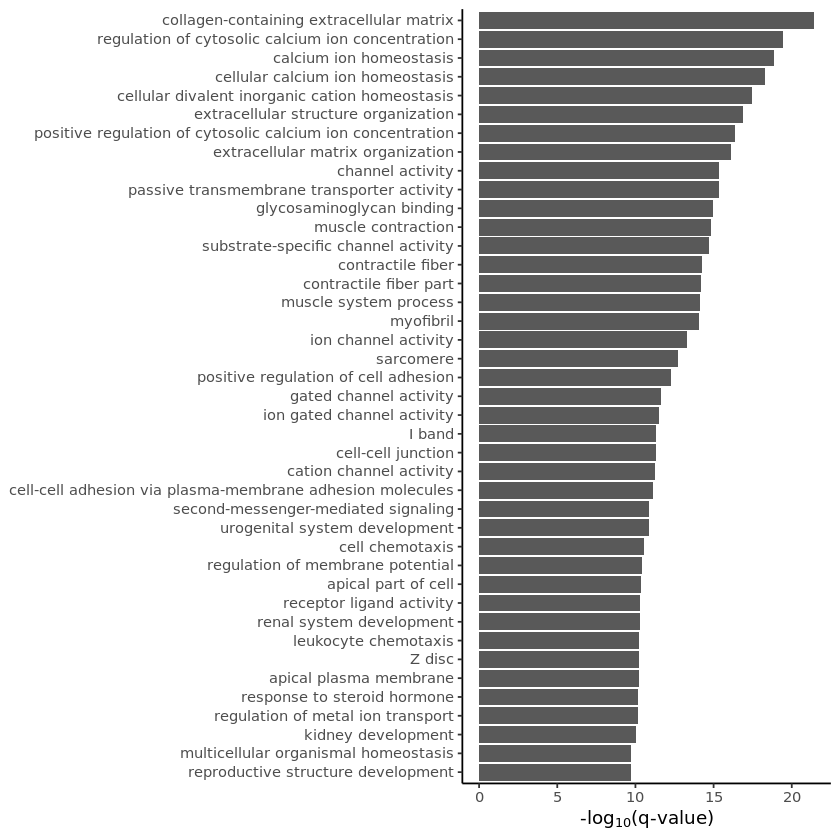

In [80]:
dge_go_df <- make_ea_df(dge_go_res, ea_type = "GO")
# ea_plot(dge_go_df %>% dplyr::top_n(n = -40, wt = qval))
ea_plot(dge_go_df %>% dplyr::filter(qval < pval_thresh))
ggsave(paste0(dirs$figures_dir, "/enrichment/", unified_dsets[dset_idx], "_DEG_all_gene_set.png"), last_plot())

Saving 6.67 x 6.67 in image


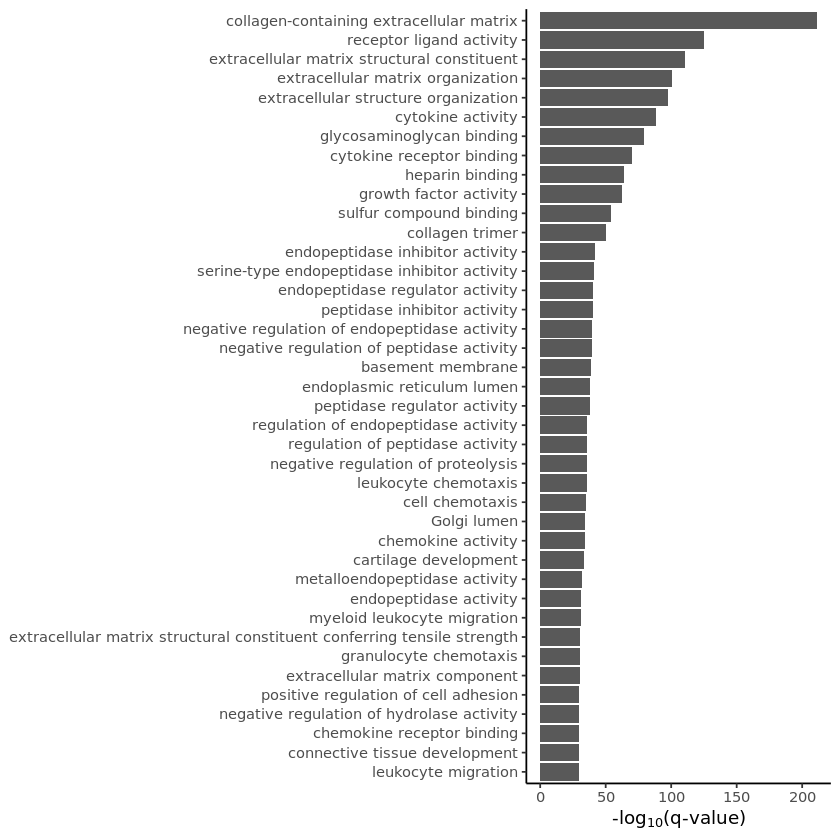

In [81]:
dge_m_go_df <- make_ea_df(dge_m_go_res, ea_type = "GO")
# ea_plot(dge_m_go_df %>% dplyr::top_n(n = -40, wt = qval))
ea_plot(dge_m_go_df %>% dplyr::filter(qval < pval_thresh), top = 40)
ggsave(paste0(dirs$figures_dir, "/enrichment/", unified_dsets[dset_idx], "_DEG_matrisome_gene_set.png"), last_plot())

## Pathway

In [82]:
dge_kegg_res <- enrichKEGG(filtered_dge_df$entrez_gene_id, organism = "hsa")
dge_m_kegg_res <- enrichKEGG(filtered_dge_m_df$entrez_gene_id, organism = "hsa")

Saving 6.67 x 6.67 in image


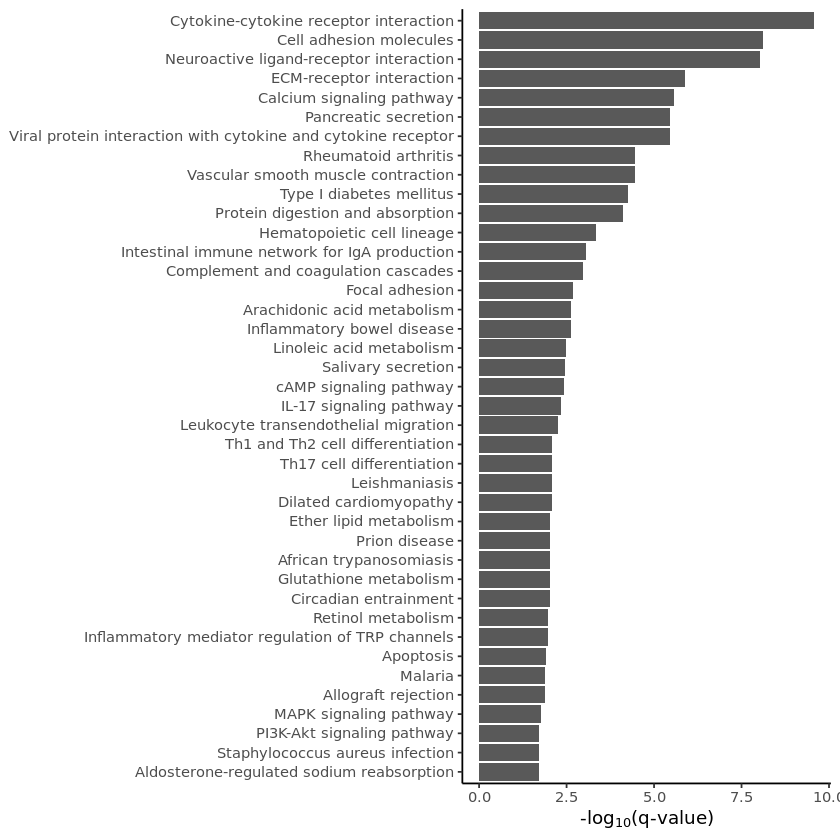

In [83]:
dge_kegg_df <- make_ea_df(dge_kegg_res, ea_type = "KEGG")
# ea_plot(dge_kegg_df %>% dplyr::top_n(n = -40, wt = qval))
ea_plot(dge_kegg_df %>% dplyr::filter(qval < pval_thresh))
ggsave(paste0(dirs$figures_dir, "/enrichment/", unified_dsets[dset_idx], "_DEG_all_pathway.png"), last_plot())

Saving 6.67 x 6.67 in image


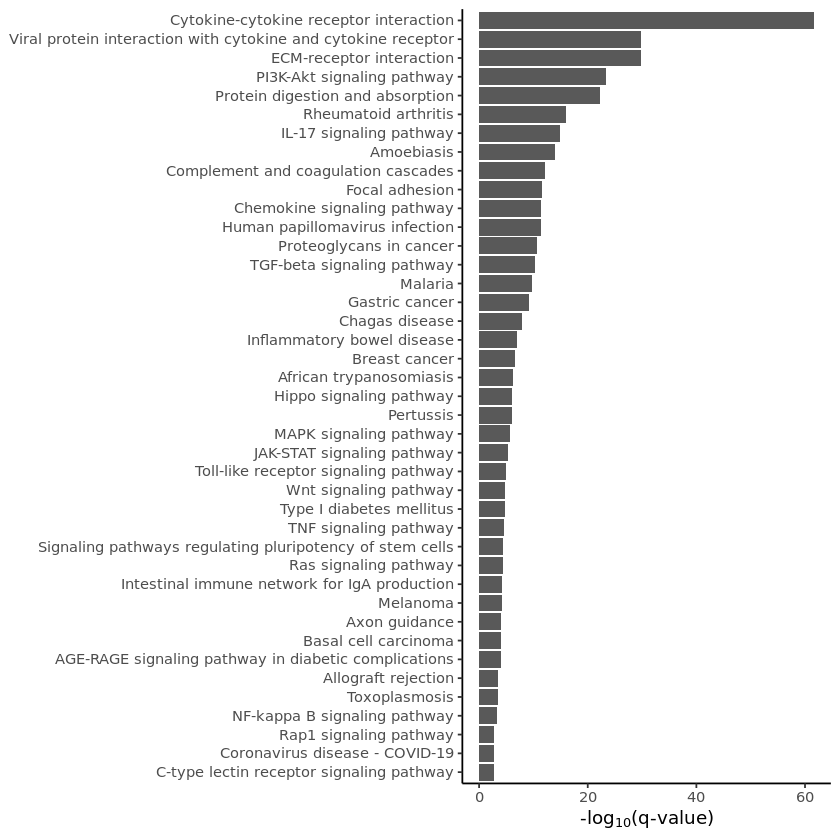

In [84]:
dge_m_kegg_df <- make_ea_df(dge_m_kegg_res, ea_type = "KEGG")
# ea_plot(dge_m_kegg_df %>% dplyr::top_n(n = -40, wt = qval))
ea_plot(dge_m_kegg_df %>% dplyr::filter(qval < pval_thresh))
ggsave(paste0(dirs$figures_dir, "/enrichment/", unified_dsets[dset_idx], "_DEG_matrisome_pathway.png"), last_plot())

## Write out

In [85]:
write_tsv(
    dge_go_df,
    paste0(dirs$analysis_dir, "/enrichment/", unified_dsets[dset_idx], "_DEG_all_gene_set.tsv"),
)

write_tsv(
    dge_m_go_df,
    paste0(dirs$analysis_dir, "/enrichment/", unified_dsets[dset_idx], "_DEG_matrisome_gene_set.tsv")
)

write_tsv(
    dge_kegg_df,
    paste0(dirs$analysis_dir, "/enrichment/", unified_dsets[dset_idx], "_DEG_all_pathway.tsv")
)

write_tsv(
    dge_m_kegg_df,
    paste0(dirs$analysis_dir, "/enrichment/", unified_dsets[dset_idx], "_DEG_matrisome_pathway.tsv")
)

# FIGO

In [86]:
filtered_lr_df <- lr_df %>%
    dplyr::select(one_of("geneID", colnames(.)[startsWith(colnames(.), "mean")])) %>%
    dplyr::mutate(votes = rowSums(.[, -1] > perm_thresh)) %>%
    dplyr::filter(votes >= vote_thresh) %>%
    inner_join(gene2id_df, by = c("geneID" = "hugo_symbol")) %>%
    dplyr::select(geneID, entrez_gene_id, everything())

In [87]:
filtered_anova_df <- anova_df %>%
    dplyr::filter(qval < pval_thresh) %>%
    inner_join(gene2id_df, by = c("geneID" = "hugo_symbol")) %>%
    dplyr::select(geneID, entrez_gene_id, everything())

In [88]:
filtered_figo_network_df <- network_mm_gs_df %>%
    dplyr::select(geneID, module, mm_pval, mm_cor) %>%
    inner_join(condensed_me_df, by = "module") %>%
    inner_join(gene2id_df, by = c("geneID" = "hugo_symbol")) %>%
    dplyr::select(geneID, entrez_gene_id, everything()) %>%
    dplyr::filter(me_figo_min_qval < pval_thresh) %>%
    # Make sure genes are significant members of the module
    dplyr::filter(mm_pval < pval_thresh)

In [89]:
figo_entrezIDs <- filtered_lr_df$entrez_gene_id %>% 
    union(filtered_anova_df$entrez_gene_id) %>% 
    union(filtered_figo_network_df$entrez_gene_id)
figo_geneIDs <- filtered_lr_df$geneID %>% 
    union(filtered_anova_df$geneID) %>% 
    union(filtered_figo_network_df$geneID)

In [90]:
length(figo_entrezIDs) == length(figo_geneIDs)

[1] TRUE

## Gene-set

In [91]:
figo_go_res <- enrichGO(figo_entrezIDs, "org.Hs.eg.db", ont = "ALL", readable = TRUE)

Saving 6.67 x 6.67 in image


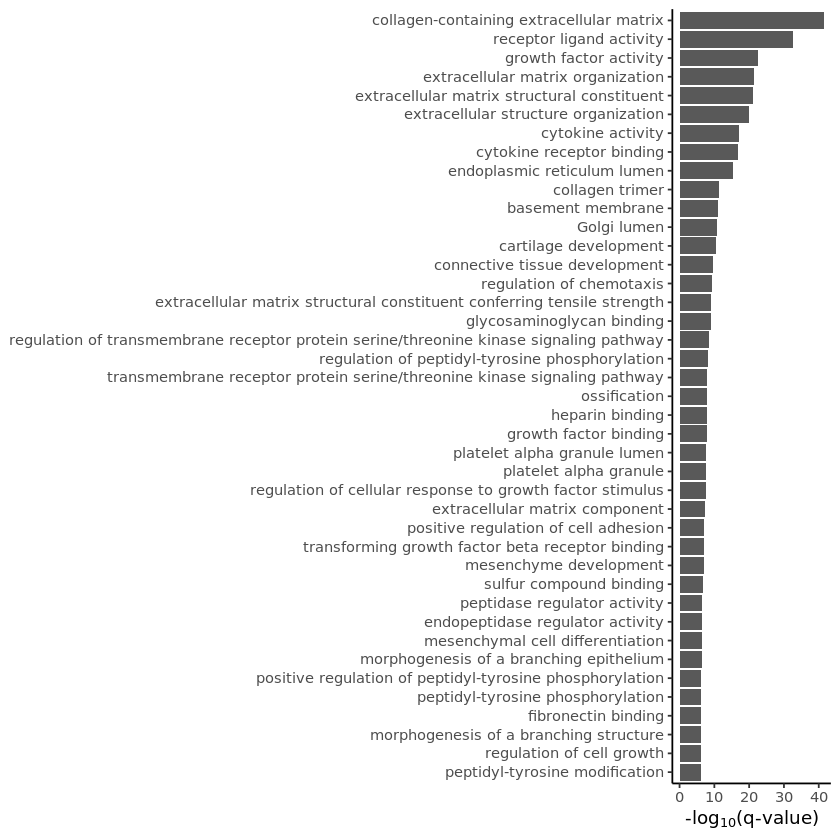

In [92]:
figo_go_df <- make_ea_df(figo_go_res, ea_type = "GO")
# ea_plot(figo_go_df %>% dplyr::top_n(n = -40, wt = qval))
ea_plot(figo_go_df %>% dplyr::filter(qval < pval_thresh))
ggsave(paste0(dirs$figures_dir, "/enrichment/", unified_dsets[dset_idx], "_figo_gene_set.png"), last_plot())

## Pathway

In [93]:
figo_kegg_res <- enrichKEGG(figo_entrezIDs, organism = "hsa")

Saving 6.67 x 6.67 in image


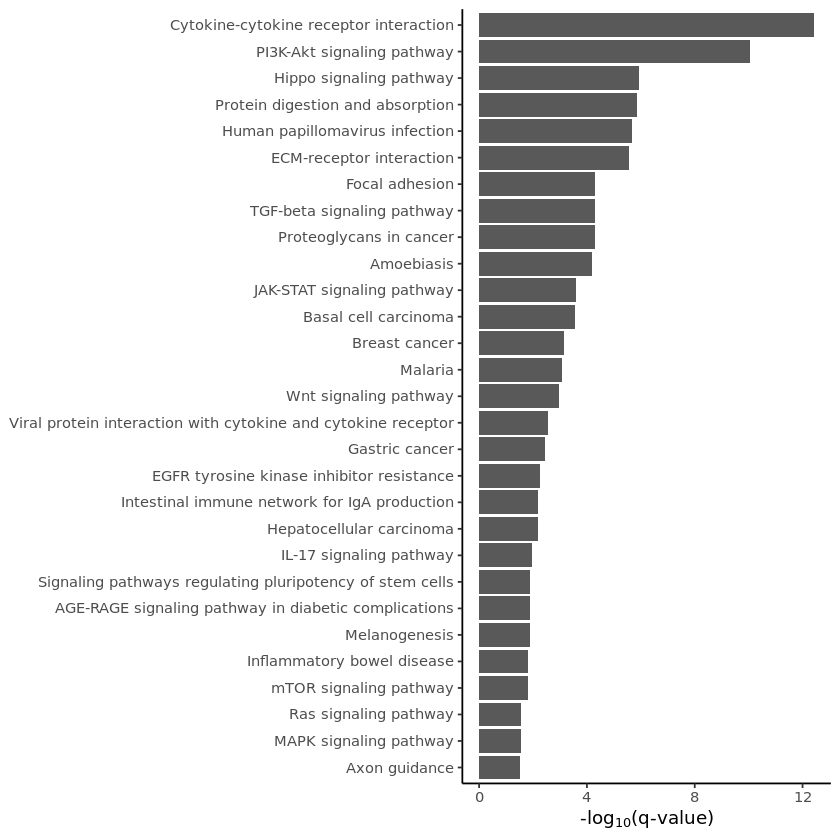

In [94]:
figo_kegg_df <- make_ea_df(figo_kegg_res, ea_type = "KEGG")
# ea_plot(figo_kegg_df %>% dplyr::top_n(n = -40, wt = qval))
ea_plot(figo_kegg_df %>% dplyr::filter(qval < pval_thresh))
ggsave(paste0(dirs$figures_dir, "/enrichment/", unified_dsets[dset_idx], "_figo_pathway.png"), last_plot())

## Write out

In [95]:
write_tsv(
    figo_go_df,
    paste0(dirs$analysis_dir, "/enrichment/", unified_dsets[dset_idx], "_figo_gene_set.tsv")
)

write_tsv(
    figo_kegg_df,
    paste0(dirs$analysis_dir, "/enrichment/", unified_dsets[dset_idx], "_figo_pathway.tsv")
)

# Survival

In [96]:
filtered_coxph_df <- coxph_df %>%
    inner_join(gene2id_df, by = c("geneID" = "hugo_symbol")) %>%
    dplyr::filter(gene_qval < pval_thresh)

In [97]:
filtered_cor_df <- cor_df %>%
    inner_join(gene2id_df, by = c("geneID" = "hugo_symbol")) %>%
    dplyr::filter(qval < pval_thresh)

In [98]:
filtered_coxph_network_df <- network_mm_gs_df %>%
    dplyr::select(geneID, module, mm_pval, mm_cor) %>%
    inner_join(condensed_me_df, by = "module") %>%
    inner_join(gene2id_df, by = c("geneID" = "hugo_symbol")) %>%
    dplyr::select(geneID, entrez_gene_id, everything()) %>%
    dplyr::filter(me_vital_qval < pval_thresh) %>%
    # Make sure genes are significant members of the module
    dplyr::filter(mm_pval < pval_thresh)

In [99]:
survival_entrezIDs <- filtered_coxph_df$entrez_gene_id %>%
    union(filtered_cor_df$entrez_gene_id) %>%
    union(filtered_coxph_network_df$entrez_gene_id)

survival_geneIDs <- filtered_coxph_df$geneID %>%
    union(filtered_cor_df$geneID) %>%
    union(filtered_coxph_network_df$geneID)

In [100]:
length(survival_geneIDs) == length(survival_geneIDs)

[1] TRUE

## Gene-set

In [101]:
survival_go_res <- enrichGO(survival_entrezIDs, "org.Hs.eg.db", ont = "ALL", readable = TRUE)

Saving 6.67 x 6.67 in image


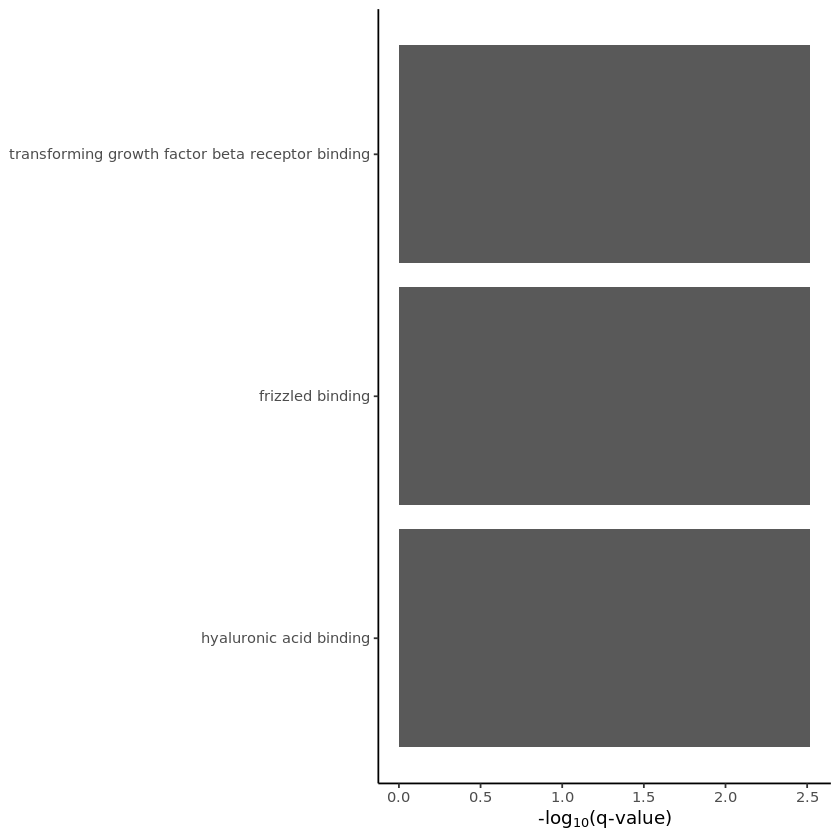

In [102]:
survival_go_df <- make_ea_df(survival_go_res, ea_type = "GO")
ea_plot(survival_go_df %>% dplyr::filter(qval < pval_thresh), top = 10)
ggsave(paste0(dirs$figures_dir, "/enrichment/", unified_dsets[dset_idx], "_survival_gene_set.png"), last_plot())

In [103]:
survival_kegg_res <- enrichKEGG(survival_entrezIDs, organism = "hsa")

Saving 6.67 x 6.67 in image


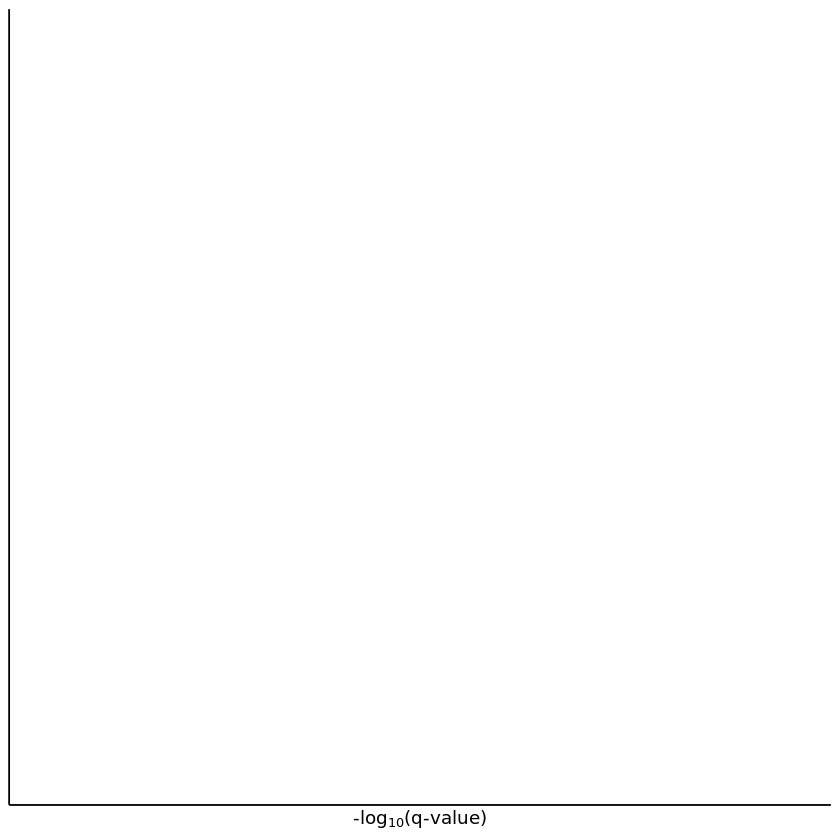

In [104]:
survival_kegg_df <- make_ea_df(survival_kegg_res, ea_type = "KEGG")
# ea_plot(figo_kegg_df %>% dplyr::top_n(n = -40, wt = qval))
ea_plot(survival_kegg_df %>% dplyr::filter(qval < pval_thresh))
ggsave(paste0(dirs$figures_dir, "/enrichment/", unified_dsets[dset_idx], "_survival_pathway.png"), last_plot())

## Write out

In [105]:
write_tsv(
    survival_go_df,
    paste0(dirs$analysis_dir, "/enrichment/", unified_dsets[dset_idx], "_survival_gene_set.tsv")
)

write_tsv(
    survival_kegg_df,
    paste0(dirs$analysis_dir, "/enrichment/", unified_dsets[dset_idx], "_survival_pathway.tsv")
)